In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
import glob

In [2]:
img_path = glob.glob('./birds Auklet/*/*.jpg')

In [3]:
len(img_path)

160

In [4]:
img_path[:5],img_path[-5:]

(['./birds Auklet\\005.Crested_Auklet\\0.jpg',
  './birds Auklet\\005.Crested_Auklet\\1.jpg',
  './birds Auklet\\005.Crested_Auklet\\10.jpg',
  './birds Auklet\\005.Crested_Auklet\\11.jpg',
  './birds Auklet\\005.Crested_Auklet\\12.jpg'],
 ['./birds Auklet\\008.Rhinoceros_Auklet\\5.jpg',
  './birds Auklet\\008.Rhinoceros_Auklet\\6.jpg',
  './birds Auklet\\008.Rhinoceros_Auklet\\7.jpg',
  './birds Auklet\\008.Rhinoceros_Auklet\\8.jpg',
  './birds Auklet\\008.Rhinoceros_Auklet\\9.jpg'])

In [5]:
img_path[1].split("\\")[1].split(".")[0]

'005'

In [6]:
import random
random.shuffle(img_path)

In [7]:
# all_img_label = []
# for p in img_path:
#     if p.split("\\")[1].split(".")[0] == '005':
#         all_img_label.append(0)
#     elif p.split("\\")[1].split(".")[0] == '006':
#         all_img_label.append(1)
#     elif p.split("\\")[1].split(".")[0] == '007':
#         all_img_label.append(2)
#     else:
#         all_img_label.append(3)

In [8]:
all_img_label = [int(p.split("\\")[1][2])-5 for p in img_path]

In [9]:
all_img_label[-5:]

[0, 2, 3, 1, 3]

In [10]:
def load_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,[256,256])
    image = tf.cast(image,tf.float32)
    image = image/255.0
    return image

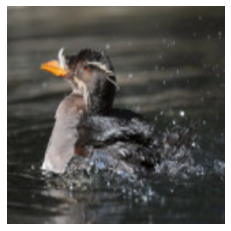

75 Rhinoceros_Auklet


In [11]:
import matplotlib.pyplot as plt
rr = random.randint(0, len(img_path))
img_path_ = img_path[rr]
plt.imshow(load_preprocess_image(img_path_))
plt.axis("off")
plt.show()
if all_img_label[rr]==0:
    print(rr, np.where(all_img_label[rr]==0, "Crested_Auklet", 'not 0'))
elif all_img_label[rr]==1:
    print(rr, np.where(all_img_label[rr]==1, "Least_Auklet", 'not 1'))
elif all_img_label[rr]==2:
    print(rr, np.where(all_img_label[rr]==2, "Parakeet_Auklet", 'not 2'))
else:
    print(rr, np.where(all_img_label[rr]==3, "Rhinoceros_Auklet", 'not 3'))

In [12]:
train_ds = tf.data.Dataset.from_tensor_slices(img_path[:int(len(img_path)*0.85)])
test_ds = tf.data.Dataset.from_tensor_slices(img_path[int(len(img_path)*0.85):])

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_img_ds = train_ds.map(load_preprocess_image,num_parallel_calls=AUTOTUNE)
test_img_ds = test_ds.map(load_preprocess_image,num_parallel_calls=AUTOTUNE)

In [14]:
train_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_img_label[:int(len(img_path)*0.85)],tf.int64))
test_label_ds=all_img_label[int(len(img_path)*0.85):]

In [15]:
image_label_ds = tf.data.Dataset.zip((train_img_ds, train_label_ds))

In [16]:
val_count = int(len(img_path)*0.85*0.2)
train_count = (int(len(img_path)*0.85)) - val_count

In [17]:
val_count,train_count

(27, 109)

In [18]:
val_data = image_label_ds.take(val_count)
train_data = image_label_ds.skip(val_count)

In [19]:
train_data.take(5),test_ds,test_img_ds

(<TakeDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 <ParallelMapDataset element_spec=TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None)>)

In [20]:
BATCH_SIZE = 16
train_data = train_data.repeat()
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(AUTOTUNE)

In [21]:
val_data = val_data.batch(BATCH_SIZE)
test_img_ds = test_img_ds.batch(BATCH_SIZE)

In [22]:
train_data,val_data,test_img_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>)

In [23]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(16,(3,3),input_shape=(256,256,3),activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPool2D())
# model.add(tf.keras.layers.Conv2D(32,(3,3),activation="relu"))
# model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(16,activation="relu"))
model.add(tf.keras.layers.Dense(4,activation="softmax"))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 16)     64        
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 16)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 852
Trainable params: 820
Non-trainable pa

In [25]:
model.compile(optimizer="adam",
             loss="sparse_categorical_crossentropy",
             metrics=['acc'])

In [26]:
steps_per_epoch = train_count//BATCH_SIZE
validation_steps = val_count//BATCH_SIZE

In [27]:
%%time
history = model.fit(train_data,epochs=30,steps_per_epoch=16,validation_data=val_data)

Epoch 1/30
16/16 [==============================] - 11s 591ms/step - loss: 1.3333 - acc: 0.3047 - val_loss: 1.3779 - val_acc: 0.2593
Epoch 2/30
16/16 [==============================] - 9s 571ms/step - loss: 1.2861 - acc: 0.4062 - val_loss: 1.3694 - val_acc: 0.3333
Epoch 3/30
16/16 [==============================] - 8s 523ms/step - loss: 1.2275 - acc: 0.4766 - val_loss: 1.3642 - val_acc: 0.3333
Epoch 4/30
16/16 [==============================] - 8s 531ms/step - loss: 1.2151 - acc: 0.4531 - val_loss: 1.3566 - val_acc: 0.3704
Epoch 5/30
16/16 [==============================] - 8s 522ms/step - loss: 1.2131 - acc: 0.4570 - val_loss: 1.3515 - val_acc: 0.3704
Epoch 6/30
16/16 [==============================] - 9s 550ms/step - loss: 1.1661 - acc: 0.4883 - val_loss: 1.3434 - val_acc: 0.3704
Epoch 7/30
16/16 [==============================] - 9s 534ms/step - loss: 1.1761 - acc: 0.4922 - val_loss: 1.3342 - val_acc: 0.3704
Epoch 8/30
16/16 [==============================] - 9s 558ms/step - loss: 1

In [28]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

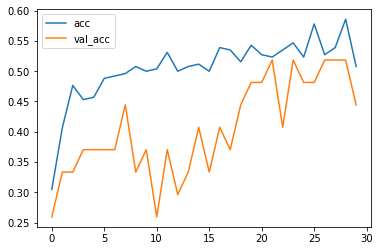

In [29]:
plt.plot(history.epoch, history.history.get('acc'), label='acc')
plt.plot(history.epoch, history.history.get('val_acc'), label='val_acc')
plt.legend()

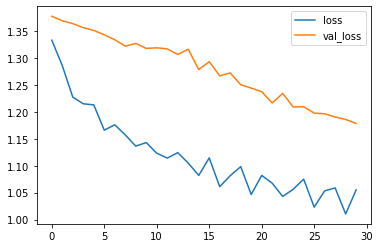

In [30]:
plt.plot(history.epoch, history.history.get('loss'), label='loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='val_loss')
plt.legend()

In [31]:
pred = model.predict(test_img_ds)

2/2 [==============================] - 0s 82ms/step


In [32]:
#模型预测的结果是该图像所属不同类别的概率，属于哪个类别的概率大就属于哪个类别（np.argmax）
pred_=np.argmax(pred,axis=1)
pred_

array([0, 3, 2, 0, 1, 1, 1, 2, 3, 2, 3, 0, 1, 3, 3, 2, 0, 3, 0, 1, 0, 1,
       2, 0], dtype=int64)

In [33]:
test_label_ds

[2, 1, 0, 0, 2, 0, 0, 2, 3, 1, 3, 0, 1, 2, 1, 0, 2, 0, 0, 0, 2, 3, 1, 3]

In [34]:
from sklearn.metrics import classification_report

In [35]:
print(classification_report(test_label_ds,pred_))

              precision    recall  f1-score   support

           0       0.43      0.33      0.38         9
           1       0.17      0.20      0.18         5
           2       0.20      0.17      0.18         6
           3       0.33      0.50      0.40         4

    accuracy                           0.29        24
   macro avg       0.28      0.30      0.28        24
weighted avg       0.30      0.29      0.29        24

